# Tutorial for WebbPSF: Computing Simulated Point Spread Functions for JWST

This tutorial will walk you through the basics of using the WebbPSF package to calculate PSFs for JWST. This focuses on the command-line/programming interface rather than the graphical interface. Let's begin.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'

Populating the interactive namespace from numpy and matplotlib


## Getting Started

We assume you have already installed webbpsf from PyPI or some other source::
        
        pip install webbpsf --upgrade

In [2]:
import webbpsf

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

In [4]:
webbpsf.setup_logging(filename='my_log.txt')

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
WebbPSF log outputs will also be saved to file my_log.txt


## First PSFs

Now let's get started with some calculations. WebbPSF provides a set of five objects corresponding to JWST's four instruments plus the FGS. To calculate a PSF, we first instantiate one of these: 

In [5]:
nc = webbpsf.NIRCam()

And then call its ``calcPSF`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

In [6]:
psf = nc.calcPSF(nlambda=5, fov_arcsec=2)

[webbpsf] Setting up PSF calculation for NIRCam
[  poppy] Computing wavelength weights using synthetic photometry for F200W...
[webbpsf] NIRCam pixel scale updated to 0.031700 arcsec/pixel to match the requested wavelength range.
[webbpsf] PSF calc using fov_arcsec = 2.000000, oversample = 4, number of wavelengths = 5
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Pupil: Loaded amplitude transmission from /Users/mperrin/software/webbpsf-data/pupil_RevV.fits
[  poppy] JWST Pupil: Loaded OPD from /Users/mperrin/software/webbpsf-data/NIRCam/OPD/OPD_RevV_nircam_155.fits
[  poppy] The supplied pupil OPD is a datacube but no slice was specified. Defaulting to use slice 0.
[  poppy] Added pupil plane: JWST Pupil
[  poppy] Added detector: NIRCam detector, with pixelscale=0.031700 arcsec/pixel and oversampling=4
[  poppy] Calculating PSF with 5 wavelengths
[  poppy]  Propagating wavelength = 1.8016e-06 meters
[  poppy]  Propagating wavel

As you can see, the log output can be fairly verbose. This is often helpful in terms of understanding what's going on, but for purposes of this documentation it will make for easier reading to turn off display of informational messages:

In [7]:
webbpsf.setup_logging('ERROR')

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can display the PSF that we have just created:

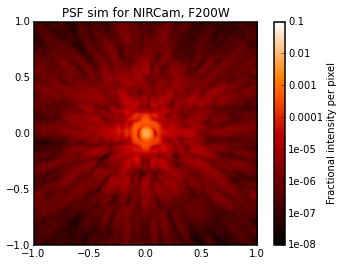

In [8]:
webbpsf.display_PSF(psf)

The default behavior of WebbPSF is to compute *oversampled* PSFs (i.e. sampled more finely than the detector pixel scale) by a factor of 4. However, it also produces a version of the same PSF that has been downsampled onto the detector scale. This is saved as an image extension in the same result file:

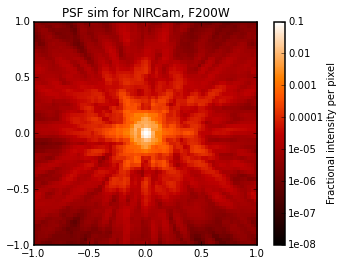

In [12]:
webbpsf.display_PSF(psf,ext='DET_SAMP')

Instruments have properties corresponding to their configurable options, typically the bandpass filter and optional image plane and pupil plane masks.  

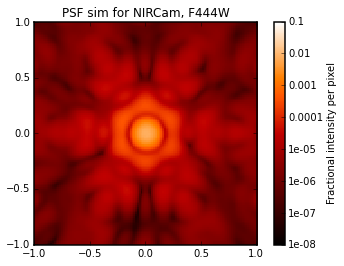

In [13]:
nc.filter='F444W'
psf444 = nc.calcPSF(fov_arcsec=2)
webbpsf.display_PSF(psf444)

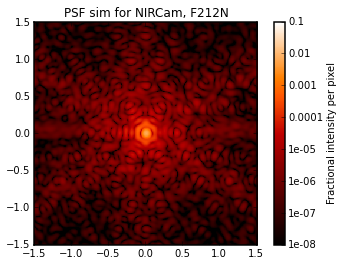

In [14]:
nc.filter='F212N'
psf212 = nc.calcPSF(fov_arcsec=3)
webbpsf.display_PSF(psf212)

More complicated instrumental configurations are available by setting the instrument’s attributes. For instance, one can create an instance of MIRI and configure it for coronagraphic observations, as follows. This also shows off the ability to display the intermediate optical planes during a calculation:

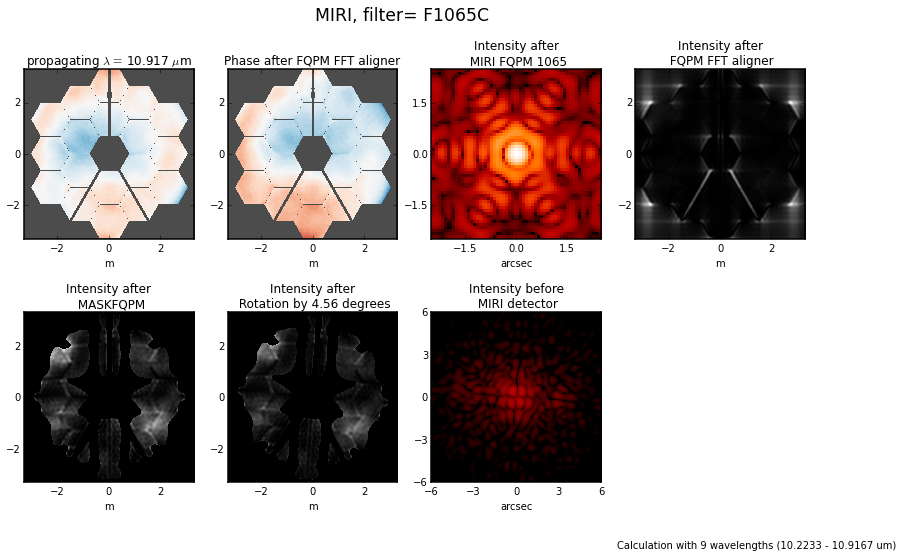

In [15]:
# optional: make the plot bigger so we can see everything more easily
plt.figure(figsize=(14, 8))

miri = webbpsf.MIRI()
miri.filter = 'F1065C'
miri.image_mask = 'FQPM1065'
miri.pupil_mask = 'MASKFQPM'
miri_coron = miri.calcPSF(display=True)
plt.savefig('fig_miri_coron_f1065c.png', dpi=100)

##  More Examples

Here are some other example calculations taken from the rest of the ``webbpsf`` documentation. 

Some of these differ`s cosmetically from the code there: this notebook contains some extra function calls to set an aesthetically pleasing size for each plot, and to save the outputs to PNGs for inclusion in the documentation source code. These lines are left out of the example docs HTML page just to streamline it a bit.

In [44]:
insts = ['NIRCam','NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
filts = ['F210M', 'F444W', 'F110W', 'F380M', 'F1000W', 'FGS']

psfs = {}
for i, (instname, filt) in enumerate(zip(insts, filts)):
    inst = webbpsf.Instrument(instname)
    inst.filter = filt
    psf = inst.calcPSF(fov_arcsec=5.0)
    psfs[instname+filt] = psf
    print inst

<JWST: NIRCam>
<JWST: NIRCam>
<JWST: NIRSpec>
<JWST: NIRISS>
<JWST: MIRI>
<JWST: FGS>


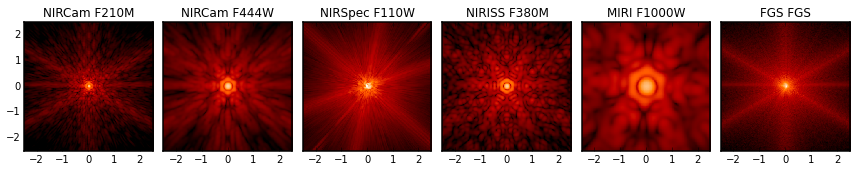

In [63]:
plt.figure(figsize=(16*0.75,3*0.75))
plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.9)
for i, (instname, filt) in enumerate(zip(insts, filts)):
    ax = plt.subplot(1,6,1+i)
    webbpsf.display_PSF(psfs[instname+filt], colorbar=False, title=instname+" "+filt, vmax=0.03, imagecrop=5)
    if i > 0:
        ax.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig('fig_instrument_comparison.png', dpi=150)

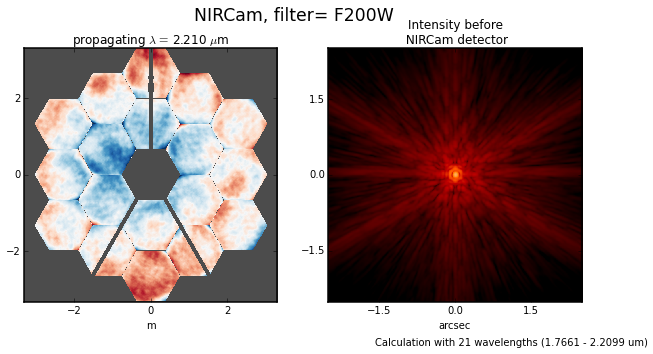

In [64]:
plt.figure(figsize=(10,5))
nc = webbpsf.NIRCam()
nc.filter =  'F200W'
nc.calcPSF(display=True)    
plt.savefig('fig1_nircam_f200w.png', dpi=120)

##Displaying a PSF as an image and as an encircled energy plot


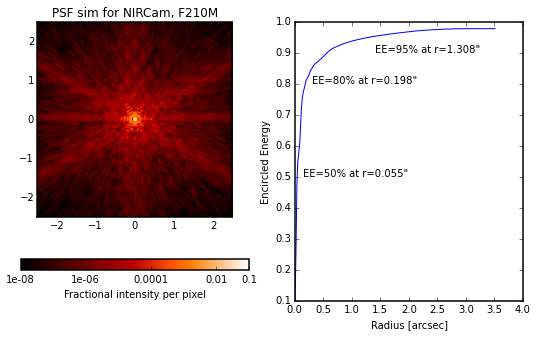

In [28]:
#create a NIRCam instance and calculate a PSF for F210M
nircam = webbpsf.NIRCam()
nircam.filter = 'F210M'
psf210 = nircam.calcPSF(oversample=2)

# display the PSF and plot the encircled energy
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
webbpsf.display_PSF(psf210, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_EE(psf210, ax=axis2)

psf210.writeto('nircam_F210M.fits', clobber=True)
plt.savefig('fig_example_plot_nircam_f210m.png')